# Data Preparation


## Dataset
For this project I have used four different datasets to create data for my analysis. I used the [Zillow Dataset](https://www.zillow.com/research/data/) to get the housing prices for neighborhoods in Chicago. For crime I used the Chicago Crimes dataset that is publically available on [the official website of the City of Chicago](https://data.cityofchicago.org/Public-Safety/Crimes-2019/w98m-zvie) under the following [Terms of Use](https://www.chicago.gov/city/en/narr/foia/data_disclaimer.html). In order to normalize the crime counts based on the neighborhood poplulations, I used the 2010 Census data for the population at neighborhood level. The data is available from the [Datahub website](https://datahub.cmap.illinois.gov/dataset/community-data-snapshots-raw-data/resource/8c4e096e-c90c-4bef-9cf1-9028d094296e?inner_span=True). Finally for mapping the latitude-longitude coordinates in the crime dataset to Zillow defined neighborhoods, I used the nieghborhood boundary data generated in the [github repository](https://github.com/mashvisor/us-neighborhoods-boundaries/blob/master/out/csv/IL-Regions.csv).  

# Data Creation  

## Step 1: Preparing Crime Dataset
First we load the crime dataset from the [Chicago Open Data website](https://data.cityofchicago.org/Public-Safety/Crimes-2019/w98m-zvie). The downloaded csv is available in the data folder in the repository.

In [1]:
import pandas as pd
import json

crime_data = pd.read_csv('./data/input/Chicago_Crimes_Dataset_2019.csv', sep=',', header=0)

Next we remove rows with no location information and change the type of the date column.

In [2]:
crime_data = crime_data[crime_data.Latitude.notnull()]
crime_data.Date = pd.to_datetime(crime_data.Date)

In [3]:
crime_data.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11706858,JC287006,2019-05-31 22:32:00,024XX E 72ND ST,041A,BATTERY,AGGRAVATED - HANDGUN,RESTAURANT,False,False,...,7.0,43,04B,1193734.0,1857691.0,2019,11/10/2020 03:52:15 PM,41.764449,-87.565469,"(41.764448809, -87.565468967)"
1,11704699,JC284068,2019-05-29 21:55:00,022XX W CERMAK RD,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE - GARAGE,True,False,...,25.0,31,05,1161792.0,1889364.0,2019,11/10/2020 03:52:15 PM,41.852086,-87.681664,"(41.852086224, -87.681664275)"
2,11608043,JC167110,2019-02-26 21:15:00,001XX E 123RD ST,051A,ASSAULT,AGGRAVATED - HANDGUN,RESIDENCE,True,True,...,9.0,53,04A,1179294.0,1823431.0,2019,11/10/2020 03:52:15 PM,41.670776,-87.619436,"(41.670776461, -87.61943596)"
3,12148532,JD347169,2019-06-01 00:01:00,055XX W 64TH ST,1754,OFFENSE INVOLVING CHILDREN,AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY M...,RESIDENCE,True,True,...,13.0,64,02,1140680.0,1861587.0,2019,11/09/2020 03:49:27 PM,41.776275,-87.759832,"(41.77627523, -87.759832397)"
4,11936873,JC565675,2019-12-30 17:57:00,004XX W BARRY AVE,0430,BATTERY,AGGRAVATED - OTHER DANGEROUS WEAPON,SIDEWALK,False,False,...,44.0,6,04B,1172737.0,1920656.0,2019,11/09/2020 03:49:27 PM,41.937718,-87.640566,"(41.937718335, -87.64056599)"


Note that the crime data contains all incidents that occured between 01 Jan 2019 to 31st Dec 2019.

In [4]:
print(min(crime_data.Date), max(crime_data.Date))

2019-01-01 00:00:00 2019-12-31 23:55:00


We observe the types of assaults in the data and clean the data a little.

In [5]:
crime_data.groupby(['Primary Type'])['ID'].count()

Primary Type
ARSON                                  374
ASSAULT                              20602
BATTERY                              49478
BURGLARY                              9633
CONCEALED CARRY LICENSE VIOLATION      217
CRIM SEXUAL ASSAULT                    958
CRIMINAL DAMAGE                      26613
CRIMINAL SEXUAL ASSAULT                631
CRIMINAL TRESPASS                     6805
DECEPTIVE PRACTICE                   18237
GAMBLING                               142
HOMICIDE                               503
HUMAN TRAFFICKING                       13
INTERFERENCE WITH PUBLIC OFFICER      1545
INTIMIDATION                           164
KIDNAPPING                             172
LIQUOR LAW VIOLATION                   232
MOTOR VEHICLE THEFT                   8977
NARCOTICS                            14996
NON-CRIMINAL                             4
OBSCENITY                               59
OFFENSE INVOLVING CHILDREN            2314
OTHER NARCOTIC VIOLATION                 

In [6]:
crime_data.loc[crime_data['Primary Type'] == 'CRIM SEXUAL ASSAULT', 'Primary Type'] = 'CRIMINAL SEXUAL ASSAULT' 

## Step 2: Create mapping for Chicago Neighborhoods and their Latitude and Longitude Boundaries

We obtain the geolocation information for Chicago neighborhoods based on Zillow's definition of regions from the methodology used by Ahmad Hashlamoun and Mohammed Jebrini in the [Github repository](https://github.com/mashvisor/us-neighborhoods-boundaries#readme). The data used in this notenbook is [the data obtained from this method](https://github.com/mashvisor/us-neighborhoods-boundaries/blob/master/out/csv/IL-Regions.csv). We clean up and reshape the data to obtain a mapping of neighborhoods with their boundary coordinates.

In [7]:
chicago_neighborhoods = pd.read_csv('./data/input/IL-Regions.csv', sep='\t', header = None)

In [8]:
chicago_neighborhoods.head()

,0,1,2,3,4,5,6
0,IL,Cook,Chicago,Chatham,273222,218,"-87.597208915594;41.751072022231,-87.597240915..."
1,IL,Cook,Chicago,North Center,269600,163,"-87.673960915665;41.961532022427,-87.673918915..."
2,IL,Cook,Chicago,O'hare,269603,303,"-87.836540915817;41.974888022439,-87.836540915..."
3,IL,Cook,Chicago,Washington Park,275927,103,"-87.615601915611;41.783765022261,-87.615566915..."
4,IL,Cook,Chicago,Garfield Ridge,269584,271,"-87.738570915725;41.822185022297,-87.738576915..."


In [9]:
chicago_neighborhoods.columns = ['state', 'county','city', 'neighbourhood','regionid', 'total_potins', 'coordinates']

In [10]:
chicago_neighborhoods['coordinates2'] = chicago_neighborhoods['coordinates'].apply(lambda x: [[float(coord.split(';')[0]), float(coord.split(';')[1])] for coord in x.split(',')])

In [11]:
chicago_hoods = {x:y for x, y in zip(chicago_neighborhoods['regionid'], chicago_neighborhoods['coordinates2'])}
chicago_region_ids = {x:y for x, y in zip(chicago_neighborhoods['regionid'], chicago_neighborhoods['neighbourhood'])}

We can plot the coordinates on a map to see the 77 Chicago neighborhoods as defined by Zillow. 

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches
def draw_screen_poly(lats, lons, rate):
    max_rate = 0.005
    xy = list(zip(lons,lats))
    poly = matplotlib.patches.Polygon(xy, fc = 'g', ec = 'black')
    plt.gca().add_patch(poly)

(41.63, 42.05)

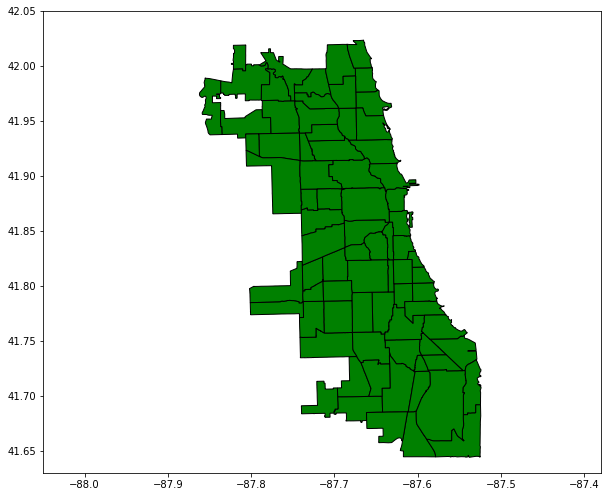

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8.5
for row in chicago_neighborhoods[['neighbourhood', 'coordinates2']].iterrows():
    hood = row[1][0]
    coord = row[1][1]
    draw_screen_poly([x[1] for x in coord], [x[0] for x in coord], 100)
plt.xlim(-88.05,-87.38)
plt.ylim(41.63,42.05)

## Step 3: Add Neighborhood information to the Crime Dataset

We the use the methodolgy given in [Craig M. Booth's github code](https://github.com/craigmbooth/chicago_neighborhood_finder/tree/739deff8f9f349720299b193b4259aa690876e52) to map the latitude-longitude data to the neighborhoods in the Zillow dataset.

In [14]:
def point_inside_polygon(x,y,poly):
    """Return True if the point described by x, y is inside of the polygon
    described by the list of points [(x0, y0), (x1, y1), ... (xn, yn)] in
    ``poly``
    Code from http://www.ariel.com.au/a/python-point-int-poly.html which
    in turn was adapted from C code found at
    http://local.wasp.uwa.edu.au/~pbourke/geometry/insidepoly/
    """
    n = len(poly)
    inside =False

    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xinters = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x,p1y = p2x,p2y

    return inside

As an example we find the neighborhood for a random coordinate point (-87.706665329, 41.800781216) and see that we obtain 'Gage Park' as the corresponding neighborhood.

In [15]:
chicago_region_ids[[e for i,e in enumerate(chicago_hoods.keys()) if point_inside_polygon(-87.706665329, 41.800781216, chicago_hoods[e])][0]]

'Gage Park'

For each crime incident in the crime dataset we obtain the corresponding Zillow regionid in a column.

***Note:-*** *This step can take several minutes to run!*

In [16]:
def addNeighToDataset(data):
    longitude = data['Longitude'].values
    latitude = data['Latitude'].values
    region = []
    for locationx, locationy in zip(longitude,latitude):
        place = [e for i,e in enumerate(chicago_hoods.keys()) if point_inside_polygon(float(locationx), float(locationy), chicago_hoods[e])]
        if len(place) == 1:
            region.append(place[0])
        else:
            region.append(None)

    data['regionid'] = region
    return data


In [17]:
crime_data_with_region = addNeighToDataset(crime_data)

In [18]:
crime_data_with_region = crime_data_with_region[crime_data_with_region.regionid.notnull()].reset_index(drop = True)
crime_data_with_region['neighborhood'] = crime_data_with_region['regionid'].apply(lambda x: chicago_region_ids[x])

In [19]:
crime_data_with_region['Date'] = pd.to_datetime(crime_data_with_region.Date)

In [20]:
crime_data_with_region.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,regionid,neighborhood
0,11706858,JC287006,2019-05-31 22:32:00,024XX E 72ND ST,041A,BATTERY,AGGRAVATED - HANDGUN,RESTAURANT,False,False,...,04B,1193734.0,1857691.0,2019,11/10/2020 03:52:15 PM,41.764449,-87.565469,"(41.764448809, -87.565468967)",269608.0,South Shore
1,11704699,JC284068,2019-05-29 21:55:00,022XX W CERMAK RD,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE - GARAGE,True,False,...,05,1161792.0,1889364.0,2019,11/10/2020 03:52:15 PM,41.852086,-87.681664,"(41.852086224, -87.681664275)",269594.0,Lower West Side
2,11608043,JC167110,2019-02-26 21:15:00,001XX E 123RD ST,051A,ASSAULT,AGGRAVATED - HANDGUN,RESIDENCE,True,True,...,04A,1179294.0,1823431.0,2019,11/10/2020 03:52:15 PM,41.670776,-87.619436,"(41.670776461, -87.61943596)",140913.0,West Pullman
3,12148532,JD347169,2019-06-01 00:01:00,055XX W 64TH ST,1754,OFFENSE INVOLVING CHILDREN,AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY M...,RESIDENCE,True,True,...,02,1140680.0,1861587.0,2019,11/09/2020 03:49:27 PM,41.776275,-87.759832,"(41.77627523, -87.759832397)",137841.0,Clearing
4,11936873,JC565675,2019-12-30 17:57:00,004XX W BARRY AVE,0430,BATTERY,AGGRAVATED - OTHER DANGEROUS WEAPON,SIDEWALK,False,False,...,04B,1172737.0,1920656.0,2019,11/09/2020 03:49:27 PM,41.937718,-87.640566,"(41.937718335, -87.64056599)",269589.0,Lake View


In [21]:
crime_data_with_region = crime_data_with_region[['ID', 'Case Number', 'Date', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Year', 'regionid', 'neighborhood']]

We save the final crime dataset that contains the neighborhood information as a csv in the data/out folder in the repository as `crime_data_with_hoods.csv`.

In [22]:
crime_data_with_region.to_csv('./data/out/crime_data_with_hoods.csv', index = False)

## Step 4: Obtaining Crime Rates for Neighborhoods (based on population)  

In order to normalize the number of crimes based on the population of each neighborhood, we include the population census data for Chicago neighborhoods. This data is created from the Chicago Open Dataset and has been downloaded from the [snapshot on Datahub](https://datahub.cmap.illinois.gov/dataset/community-data-snapshots-raw-data/resource/8c4e096e-c90c-4bef-9cf1-9028d094296e?inner_span=True). The data is available in the data/input folder of this repository and is named as `chicago_population_data.csv`. We are interested in using the 2010 census population data column (2010_POP).

In [23]:
population_data = pd.read_csv('./data/input/chicago_population_data.csv', sep = ',', header = 0)

In [24]:
population_data = population_data[['GEOG', '2010_POP']]
population_data.head()

,GEOG,2010_POP
0,Albany Park,51542
1,Archer Heights,13393
2,Armour Square,13391
3,Ashburn,41081
4,Auburn Gresham,48743


Next we join the population and crime dataset on the neighborhood names. We find that there are a few discrepencies between the two datasets which we can fix manually.

In [25]:
pop_hoods = list(population_data.GEOG.unique())
crime_hoods = list(crime_data_with_region.neighborhood.unique())

In [26]:
for n in pop_hoods:
    if n not in crime_hoods:
        print(n)

Greater Grand Crossing
O'Hare
Portage Park
The Loop


In [27]:
for n in crime_hoods:
    if n not in pop_hoods:
        print(n)

Loop
Grand Crossing
Pottage Park
O'hare


In [28]:
population_data.loc[population_data['GEOG']=='The Loop', 'GEOG'] = 'Loop'
population_data.loc[population_data['GEOG']=='Greater Grand Crossing', 'GEOG'] = 'Grand Crossing'
population_data.loc[population_data['GEOG']=='O\'Hare', 'GEOG'] = 'O\'hare'
population_data.loc[population_data['GEOG']=='Portage Park', 'GEOG'] = 'Pottage Park'

In [29]:
crime_with_pop = pd.merge(crime_data_with_region, population_data, left_on = 'neighborhood', right_on = 'GEOG', how = 'inner')
crime_with_pop = crime_with_pop.drop(columns = ['GEOG'])
crime_with_pop = crime_with_pop.rename(columns = {'2010_POP': 'population'})
crime_with_pop.head(5)

,ID,Case Number,Date,Primary Type,Description,Location Description,Arrest,Domestic,Year,regionid,neighborhood,population
0,11706858,JC287006,2019-05-31 22:32:00,BATTERY,AGGRAVATED - HANDGUN,RESTAURANT,False,False,2019,269608.0,South Shore,52010
1,11779552,JC374866,2019-08-02 06:04:00,ROBBERY,STRONG ARM - NO WEAPON,SIDEWALK,True,False,2019,269608.0,South Shore,52010
2,11897326,JC517682,2019-11-10 00:01:00,OFFENSE INVOLVING CHILDREN,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,True,True,2019,269608.0,South Shore,52010
3,24728,JC414622,2019-09-02 20:08:00,HOMICIDE,FIRST DEGREE MURDER,APARTMENT,True,True,2019,269608.0,South Shore,52010
4,11733693,JC319297,2019-06-24 05:00:00,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,APARTMENT,False,False,2019,269608.0,South Shore,52010


The final crime data is saved under the data/out as `crime_final.csv`.

In [30]:
crime_with_pop.to_csv('./data/out/crime_final.csv', index = False)

## Step 5: Preparing the Housing Prices Dataset

For the analysis we use the Zillow Home Value Index (ZHVI) for All Homes (SFR, Condo/Co-op) based on Neighborhood. This data is downloaded from [Zillow's official open data website](https://www.zillow.com/research/data/) and is available in the data/input folder. Please visit [ZHVI Overview](https://www.zillow.com/research/zhvi-methodology-2019-highlights-26221/) and [a deep-dive into it's methodology](https://www.zillow.com/research/zhvi-methodology-2019-deep-26226/) for more information about ZHVI (used in place of the housing prices for this analysis).

We filter the data for all Chicago neighborhoods. We also find the intersection of neighborhoods that we obtained from the previous steps. We find that 11 out of the 77 neighborhoods available in Zillow's neighborhood boundaries dataset are not available 1-1 in the ZHVI dataset and vice-versa. We only use the intersecting neighborhoods in order to maintain consistency between the crime and the ZHVI datasets.

In [31]:
zhvi_data = pd.read_csv('./data/input/zillow_zhvi_neighborhood_dataset.csv', sep = ',', header = 0)

In [32]:
zhvi_data = zhvi_data[zhvi_data['City'] == 'Chicago'].reset_index(drop = True)

In [33]:
zhvi_filtered = zhvi_data[zhvi_data['RegionID'].isin(chicago_region_ids.keys())].reset_index(drop = True)

In [34]:
zhvi_filtered.head(5)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30
0,269592,53,Logan Square,Neighborhood,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,151456.0,...,427048.0,427606.0,430001.0,433209.0,436357.0,438596.0,441558.0,445053.0,449245.0,454323.0
1,269566,154,Albany Park,Neighborhood,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,134612.0,...,340398.0,340724.0,340930.0,341095.0,342050.0,343416.0,344771.0,347298.0,350828.0,356003.0
2,269609,159,Uptown,Neighborhood,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,119281.0,...,302682.0,302986.0,303869.0,304993.0,305424.0,305700.0,306121.0,307510.0,309389.0,312127.0
3,269589,163,Lake View,Neighborhood,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,221230.0,...,536521.0,536425.0,537520.0,539307.0,540502.0,541240.0,542024.0,543851.0,546650.0,550731.0
4,269605,171,Rogers Park,Neighborhood,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,103821.0,...,215315.0,215820.0,216498.0,217510.0,217913.0,218352.0,219027.0,220373.0,222044.0,224347.0


Next we find the average ZHVI for Chicago Neighborhoods between 01 Jan 2019 to 31 Dec 2019.

In [35]:
zhvi_reshaped = zhvi_filtered.melt(id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName'])
zhvi_reshaped = zhvi_reshaped.rename(columns = {'variable': 'Date', 'value':'ZHVI'})
zhvi_reshaped['Date'] = pd.to_datetime(zhvi_reshaped['Date'])
zhvi_reshaped = zhvi_reshaped[(zhvi_reshaped['Date'] >= '2019-01-01') & (zhvi_reshaped['Date'] < '2020-01-01') & zhvi_reshaped['ZHVI'].notnull()]

In [36]:
zhvi_reshaped.head(5)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,ZHVI
18216,269592,53,Logan Square,Neighborhood,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,2019-01-31,430709.0
18217,269566,154,Albany Park,Neighborhood,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,2019-01-31,346712.0
18218,269609,159,Uptown,Neighborhood,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,2019-01-31,301934.0
18219,269589,163,Lake View,Neighborhood,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,2019-01-31,546449.0
18220,269605,171,Rogers Park,Neighborhood,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,2019-01-31,216135.0


In [37]:
zhvi_final = zhvi_reshaped.groupby(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName']).mean().reset_index()
zhvi_final = zhvi_final.drop(columns=['SizeRank', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'])
zhvi_final.head(5)

,RegionID,RegionName,ZHVI
0,137634,Burnside,139033.833333
1,137841,Clearing,246129.833333
2,138129,Dunning,294552.416667
3,138166,East Side,132832.333333
4,138261,Englewood,53393.166667


The final housing data is saved in the data/out folder as `housing_zhvi_final.csv`.

In [38]:
zhvi_final.to_csv('./data/out/housing_zhvi_final.csv', index = False)

## Step 6: Joining the Crime and Housing datasets  

Finally we join the crime and housing datasets based on the regionid (Zillow regionid). The final dataset is stored in the data/out folder as `final_data.csv`.

In [39]:
final_data = pd.merge(crime_with_pop, zhvi_final, left_on = 'regionid', right_on = 'RegionID',  how = 'inner')
final_data = final_data.drop(columns = ['regionid', 'neighborhood'])
final_data.head(5)

,ID,Case Number,Date,Primary Type,Description,Location Description,Arrest,Domestic,Year,population,RegionID,RegionName,ZHVI
0,11706858,JC287006,2019-05-31 22:32:00,BATTERY,AGGRAVATED - HANDGUN,RESTAURANT,False,False,2019,52010,269608,South Shore,117038.583333
1,11779552,JC374866,2019-08-02 06:04:00,ROBBERY,STRONG ARM - NO WEAPON,SIDEWALK,True,False,2019,52010,269608,South Shore,117038.583333
2,11897326,JC517682,2019-11-10 00:01:00,OFFENSE INVOLVING CHILDREN,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,True,True,2019,52010,269608,South Shore,117038.583333
3,24728,JC414622,2019-09-02 20:08:00,HOMICIDE,FIRST DEGREE MURDER,APARTMENT,True,True,2019,52010,269608,South Shore,117038.583333
4,11733693,JC319297,2019-06-24 05:00:00,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,APARTMENT,False,False,2019,52010,269608,South Shore,117038.583333


In [40]:
final_data.to_csv('./data/out/final_data.csv', index = False)